### Paxillin static image segmentation and object feature analysis

Liya Ding, 2024.04

In [2]:
import numpy as np
import seaborn as sns
import pandas as pd
import umap
from joblib import dump, load
import os.path

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.transforms import Bbox

import tifffile 
import czifile

import skimage
from skimage.morphology import remove_small_objects
from skimage.measure import label, regionprops, regionprops_table
from skimage.color import label2rgb

from scipy import ndimage
from scipy.ndimage import distance_transform_cdt
from scipy.ndimage import gaussian_filter

from sklearn.decomposition import PCA
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


# function from aicssegmentation tool
from utils.vessel_2d import filament_2d_wrapper
from utils.pre_processing_utils import intensity_normalization


### for each movie run through all the time points

In [3]:
# flag for some optinal parts
flag_plot = True
flag_plot_save = False
flag_seg_save = True
flag_csv_save = True
flag_run_all = True
flag_panel_plot = False

In [4]:
prop_df_pax_control = pd.DataFrame(columns=['filename','cell_ID','time_point','area', 'bbox_area', 'convex_area', 'eccentricity', 'equivalent_diameter', 'euler_number',
                                'extent','filled_area','label','major_axis_length','max_intensity','mean_intensity',
                                'min_intensity','minor_axis_length','orientation','perimeter','solidity',
                                'cell_edge_dist','cell_edge_orient','diff_orient','zyxin_int'])

csv_input_dir1 = '/mnt/d/lding/FA/analysis_results/pFAK_zyxin_20230423/control_pFak/weak_rescue_20241120_csv'

csv_filenames = [x for x in os.listdir(csv_input_dir1) if os.path.isfile(os.path.join(csv_input_dir1, x)) and ('Control' in x)]




In [5]:
ctrl_one_cell_list = [0,4,5,14,15,17,20,21,22,23,24,25,28,29,33,37,39,40,41,46,47,48,49,51,52,56,59,60,61,64,
                      65,69,70,75,76,79,80,82,93,94,96,102,103,104,106,107,110,112,114,115,117,122,123,126,131,134,135,136,137,139,140,141,
                 149,162,166,173,177,183,185,187,189,194,195,196,197,198,201,202,214,215,217,220,224,228,231,236,237,246,248,250,252,253,251,257,258,259,262,263,
                 267,269,270,271,277,278,285,286,287,289,293,296]

for filename in csv_filenames:
    number = int(filename[-15:-12])
    if number in ctrl_one_cell_list:
        # print(number)
        prop_df_pax = pd.read_csv(os.path.join(csv_input_dir1,filename))
        prop_df_pax_control = prop_df_pax_control.append(prop_df_pax)


In [8]:
control_obj_num = prop_df_pax_control.shape[0]

In [11]:
prop_df_pax_cont_rock = pd.DataFrame(columns=['filename','cell_ID','time_point','area', 'bbox_area', 'convex_area', 'eccentricity', 'equivalent_diameter', 'euler_number',
                                'extent','filled_area','label','major_axis_length','max_intensity','mean_intensity',
                                'min_intensity','minor_axis_length','orientation','perimeter','solidity',
                                'cell_edge_dist','cell_edge_orient','diff_orient'])

csv_input_dir1 = '/mnt/d/lding/FA/analysis_results/pFAK_zyxin_20230423/Y27_pFak/weak_rescue_csv'
                      
csv_filenames = [x for x in os.listdir(csv_input_dir1) if os.path.isfile(os.path.join(csv_input_dir1, x)) ]

y27_one_cell_list = [0,4,5,11,14,15,16,17,21,22,26,28,32,37,39,40,41,49,53,55,58,61,62,75,83,84,92,95,97,98,99,101,102,110,118,119,120,121,122,126,128,138,139,
                     140,148,150,153,154,157,158,160,161,162,163,165,167,168,169,170,174,175,180,181,185,187,189,190,192,193,194,195,
                     200,202,204,205,208,210,211,212,213,214,216,219,220,222,223,227,228,230,231,232,233,236,238,241,245,246,247,248,249,250,251,
                     252,256,257,258,260,262,264,265,266,269,270,272,273,274,275,278,280,282,285,287,288,290,291,295,297,298]


In [12]:
for filename in csv_filenames:
    number = int(filename[-15:-12])
    if number in y27_one_cell_list:
        # print(number)
        prop_df_pax = pd.read_csv(os.path.join(csv_input_dir1,filename))
        prop_df_pax_cont_rock = prop_df_pax_cont_rock.append(prop_df_pax)

In [13]:
y27_obj_num = prop_df_pax_cont_rock.shape[0]

(0.0, 1.0)

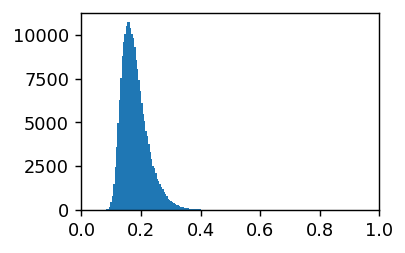

In [34]:
# combining the two
prop_df_pfak_all = prop_df_pax_control.append(prop_df_pax_cont_rock)
fig, ax = plt.subplots(1, 1, figsize=(3,2), dpi=128, facecolor='w', edgecolor='k')
plt.hist(prop_df_pfak_all['mean_intensity'],100)
plt.xlim([0,1])

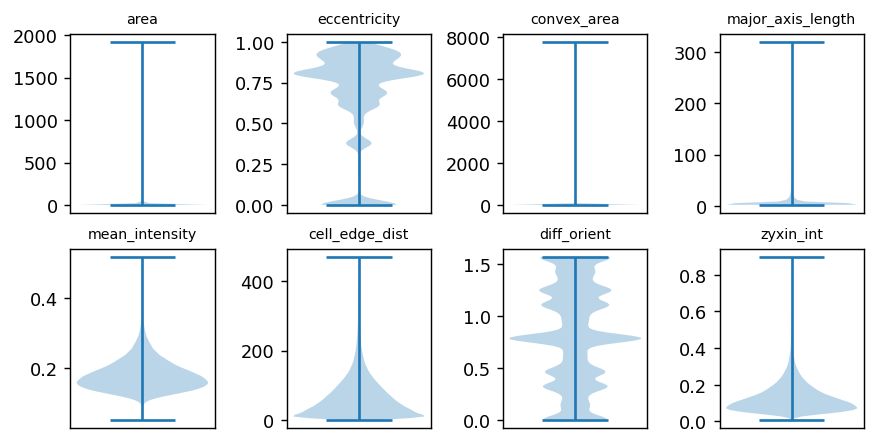

In [27]:
feature_list = ['area', 'eccentricity', 'convex_area', 'major_axis_length','mean_intensity',
                                  'cell_edge_dist','diff_orient','zyxin_int']

fig, ax = plt.subplots(2, 4, figsize=(8,4), dpi=128, facecolor='w', edgecolor='k')
# plt.subplots_adjust(left=0.3, right=0.7, top=0.8, bottom=0.2)
col_ind = 0
row_ind = 0
import seaborn as sns

for feature in feature_list:
    # sns.violinplot([prop_df_pfak_all[feature][::10].to_numpy().flat],split=True, inner="quart",color='lightblue',ax=ax[row_ind, col_ind])
    V = prop_df_pfak_all[feature].to_numpy().flat
    ax[row_ind, col_ind].violinplot(V)
    ax[row_ind, col_ind].set_title(feature,fontsize=8)
    ax[row_ind, col_ind].set_xticks([],fontsize=8)
    # ax[row_ind, col_ind].set_yticks([np.percentile(V,0.0), int(np.percentile(V,0.0)*2+np.percentile(V,100.0)*1)/3, int(np.percentile(V,0.0)*1+np.percentile(V,100.0)*2)/3,np.percentile(V,100)],fontsize=5)
    # ax[row_ind, col_ind].set_ylim([np.percentile(V,0.0),np.percentile(V,100)])
    ax[row_ind, col_ind].tick_params(axis='both', which='minor', labelsize=8)    
    
    col_ind = col_ind + 1

    if(col_ind==4):
        col_ind = 0
        row_ind = 1
fig.subplots_adjust(wspace=0.5)



In [35]:
prop_df_pfak_all.shape

(216010, 26)

In [36]:
prop_df_pax_all_selected = prop_df_pfak_all[['area', 'eccentricity', 
                                  'major_axis_length','mean_intensity', 'max_intensity',
                                  'minor_axis_length',
                                  'cell_edge_dist','diff_orient','zyxin_int']]


In [50]:

prop_df_pax_all_selected.shape

(216010, 9)

9


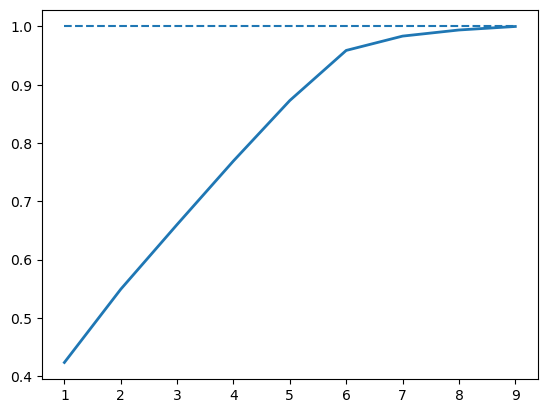

In [ ]:
import sklearn
cdf = []


prop_df_pax_all_selected_small = prop_df_pax_all_selected
prop_df_pax_all_selected_small[prop_df_pax_all_selected_small['area']>7]

cdf = sklearn.preprocessing.scale(prop_df_pax_all_selected_small, axis=0)

cdf.shape

FA_pca = sklearn.decomposition.PCA()
FA_pca.fit(cdf)

fig = plt.plot(figsize=(10,4))
cumsum = np.cumsum(FA_pca.explained_variance_ratio_)
plt.plot(np.arange(1, FA_pca.n_components_ + 1),
           cumsum, 
           '-', linewidth=2)
n_pc = FA_pca.n_components_

for i in range(FA_pca.n_components_):
    if cumsum[i]>0.999:
        n_pc = i+1
        break
print(n_pc)

plt.hlines(cumsum[n_pc-1], xmin=1, xmax=FA_pca.n_components_, linestyle='dashed')


In [59]:
weighted_cdf = cdf
weighted_cdf[:,8] = weighted_cdf[:,8]*3
weighted_cdf[:,6] = weighted_cdf[:,6]*3

<AxesSubplot:>

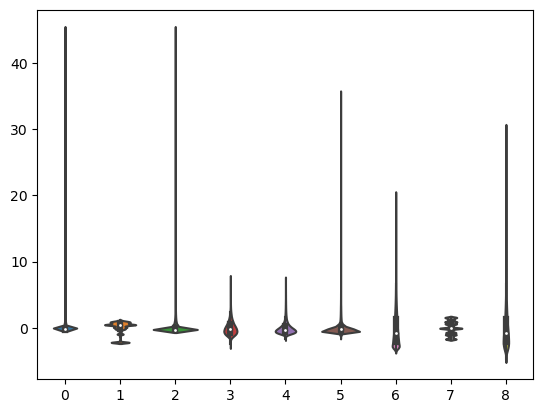

In [60]:
sns.violinplot(weighted_cdf)

<AxesSubplot:>

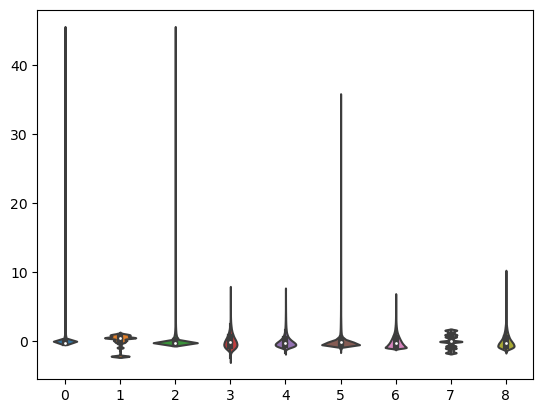

In [53]:
sns.violinplot(cdf)

Text(0.5, 1.0, 'features12')

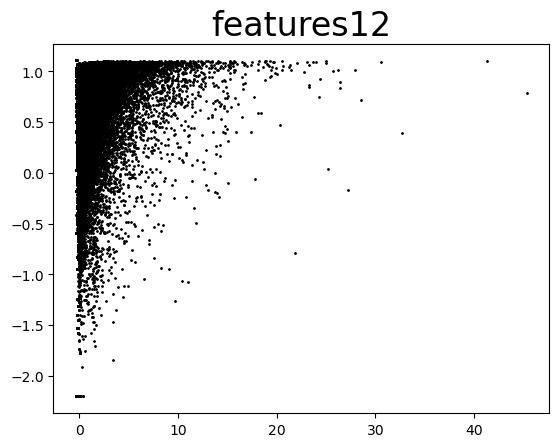

In [39]:
plt.scatter(cdf[:, 0], cdf[:, 1],c='k',s=1)
plt.title('features12', fontsize=24)

In [40]:
FA_pca.explained_variance_ratio_*100

array([42.35777575, 12.56699617, 11.10490791, 10.9087163 , 10.36772997,
        8.5858398 ,  2.45591794,  1.04942032,  0.60269583])

Text(0.5, 1.0, 'PCA-1-2')

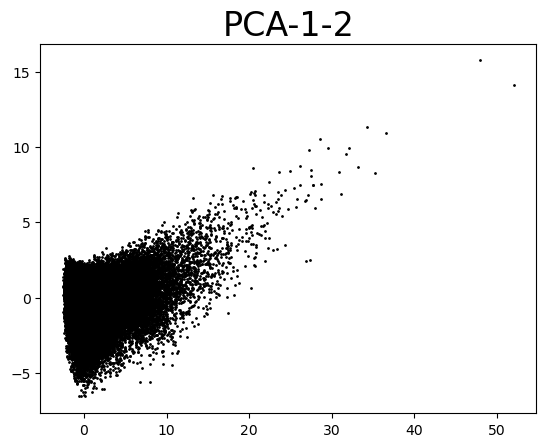

In [41]:
cdf_trans = FA_pca.transform(cdf)
plt.scatter(cdf_trans[:, 0], cdf_trans[:, 1],c='k',s=1)
plt.title('PCA-1-2', fontsize=24)

In [42]:
cdf_trans.shape

(216010, 9)

/home/ldin/anaconda3/envs/segmentation/lib/python3.7/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Text(0.5, 1.0, 'UMAP projection of the paxillin FA')

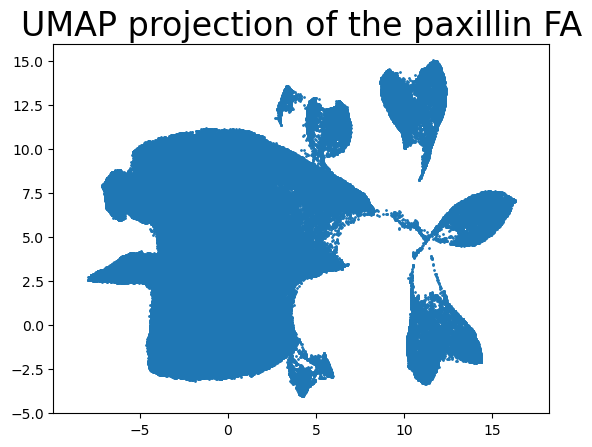

In [ ]:
import umap.umap_ as umap
scaled_pax_PCA_data = StandardScaler().fit_transform(cdf_trans)
scaled_pax_PCA_data = StandardScaler().fit_transform(cdf)
scaled_pax_PCA_data[:,0] = scaled_pax_PCA_data[:,0] *2
scaled_pax_PCA_data[:,8] = scaled_pax_PCA_data[:,8] *2
scaled_pax_PCA_data[:,6] = scaled_pax_PCA_data[:,6] *2


 
reducer = umap.UMAP(n_components=2,random_state=20)

reducer.fit(scaled_pax_PCA_data)

embedding = reducer.fit_transform(scaled_pax_PCA_data)
embedding.shape

plt.scatter(
    embedding[:, 0],
    embedding[:, 1],s=1)
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of the paxillin FA', fontsize=24)


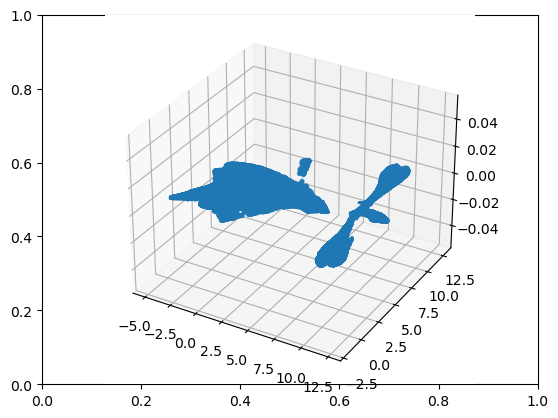

In [69]:
fig,ax =  plt.subplots(1,1)
ax = fig.add_subplot(1, 1, 1, projection='3d')
plt.scatter(
    embedding[:, 0],
    embedding[:, 1],embedding[:, 2])

<AxesSubplot:>

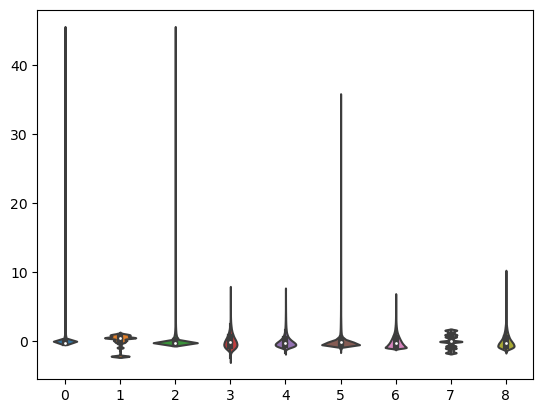

In [62]:

sns.violinplot(scaled_pax_PCA_data)

In [72]:
csv_output_dir = '/mnt/d/lding/FA/analysis_results/static_pfak_patrick_segdots_clustering_stats'
if not os.path.isdir(csv_output_dir):
    os.mkdir(csv_output_dir)

In [73]:
prop_df_pfak_all[['U0']] = embedding[:, 0].reshape([embedding.shape[0],1])
prop_df_pfak_all[['U1']] = embedding[:, 1].reshape([embedding.shape[0],1])
# prop_df_pfak_all[['U2']] = embedding[:, 2].reshape([embedding.shape[0],1])
# prop_df_pfak_all[['U3']] = embedding[:, 3].reshape([embedding.shape[0],1])
# prop_df_pfak_all[['U4']] = embedding[:, 4].reshape([embedding.shape[0],1])

prop_df_pfak_all.to_csv(os.path.join(csv_output_dir,'pfak_weakrescue_weightedumap_20241204_umap2.csv'))


In [74]:
# build the colormap with iterative tab10
tab20 = cm.get_cmap('tab20', 20)
for i in range(10):
    tab20.colors = np.concatenate([tab20.colors,tab20.colors],axis=0)    
tab20.colors = np.concatenate([np.zeros([1,4]),tab20.colors],axis=0)

newmap = cm.get_cmap('tab20', 4000+1)
newmap.colors = tab20.colors[0:4000+1,:]
newmap.colors[0,:]  = np.zeros([1,4])
newmap.colors[0,3] = 1

/home/ldin/anaconda3/envs/segmentation/lib/python3.7/site-packages/sklearn/manifold/_spectral_embedding.py:261: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  "Graph is not fully connected, spectral embedding may not work as expected."


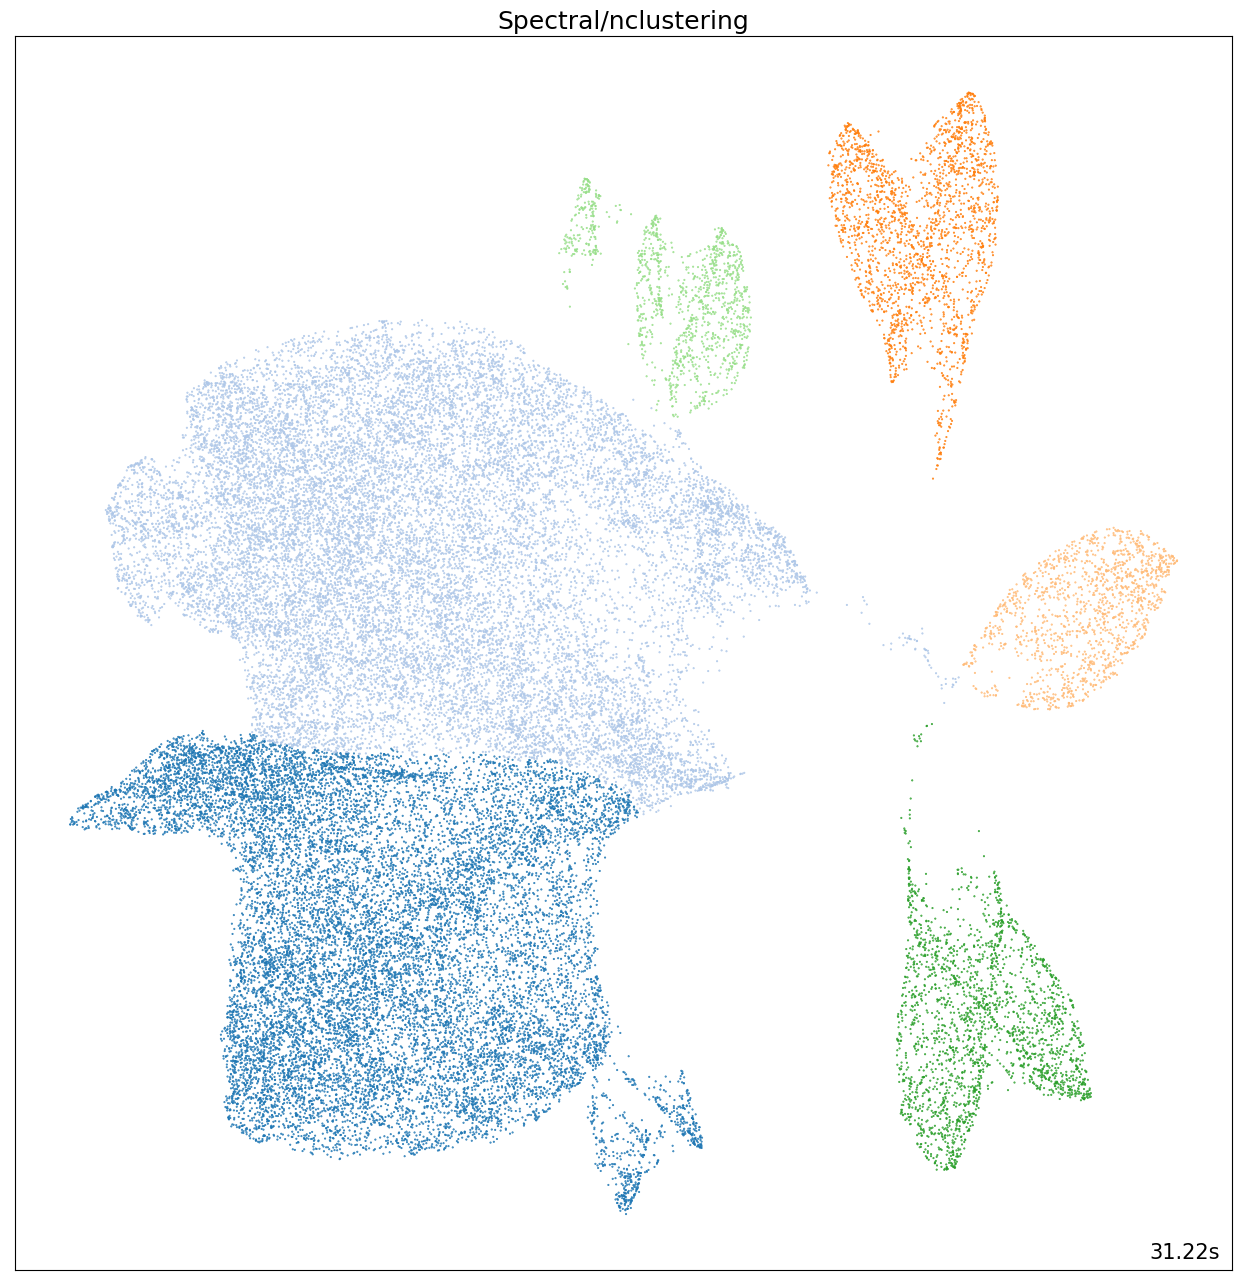

In [75]:
import time
import warnings
from itertools import cycle, islice

import matplotlib.pyplot as plt
import numpy as np

from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler

# ============
# Generate datasets. We choose the size big enough to see the scalability
# of the algorithms, but not too big to avoid too long running times
# ============
n_samples = 500
seed = 30
noisy_circles = datasets.make_circles(
    n_samples=n_samples, factor=0.5, noise=0.05, random_state=seed
)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=0.05, random_state=seed)
blobs = datasets.make_blobs(n_samples=n_samples, random_state=seed)
rng = np.random.RandomState(seed)
no_structure = rng.rand(n_samples, 2), None

# Anisotropicly distributed data
random_state = 170
X, y = datasets.make_blobs(n_samples=n_samples, random_state=random_state)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
aniso = (X_aniso, y)

# blobs with varied variances
varied = datasets.make_blobs(
    n_samples=n_samples, cluster_std=[1.0, 2.5, 0.5], random_state=random_state
)

# ============
# Set up cluster parameters
# ============
plt.figure(figsize=(26, 13))
plt.subplots_adjust(
    left=0.02, right=0.98, bottom=0.001, top=0.95, wspace=0.05, hspace=0.01
)

plot_num = 1

default_base = {
    "quantile": 0.3,
    "eps": 0.3,
    "damping": 0.9,
    "preference": -200,
    "n_neighbors": 3,
    "n_clusters": 6,
    "min_samples": 7,
    "xi": 0.05,
    "min_cluster_size": 0.01,
    "allow_single_cluster": True,
    "hdbscan_min_cluster_size": 15,
    "hdbscan_min_samples": 3,
    "random_state": 1,
}

datasets = [
    (no_structure, {}),
]

for i_dataset, (dataset, algo_params) in enumerate(datasets):
    # update parameters with dataset-specific values
    
    params = default_base.copy()

    params.update(algo_params)


    X = embedding[::5,:]
    y = np.zeros(embedding[::5,:].shape[0])

    # X, y = dataset

    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)


    # estimate bandwidth for mean shift
    bandwidth = cluster.estimate_bandwidth(X, quantile=params["quantile"])

    # connectivity matrix for structured Ward
    connectivity = kneighbors_graph(
        X, n_neighbors=params["n_neighbors"], include_self=False
    )
    # make connectivity symmetric
    connectivity = 0.5 * (connectivity + connectivity.T)

    # ============
    # Create cluster objects
    # ============
    ms = cluster.MeanShift(bandwidth=bandwidth, bin_seeding=True)
    two_means = cluster.MiniBatchKMeans(
        n_clusters=params["n_clusters"],
        random_state=params["random_state"],
    )
    spectral = cluster.SpectralClustering(
        n_clusters=params["n_clusters"],
        eigen_solver="arpack",
        affinity="nearest_neighbors",
        random_state=params["random_state"],
    )
    
    clustering_algorithms = (
        ("Spectral/nclustering", spectral),       
        ("MiniBatch/nKMeans", two_means),
    )

    for name, algorithm in clustering_algorithms:
        t0 = time.time()

        # catch warnings related to kneighbors_graph
        with warnings.catch_warnings():
            warnings.filterwarnings(
                "ignore",
                message="the number of connected components of the "
                + "connectivity matrix is [0-9]{1,2}"
                + " > 1. Completing it to avoid stopping the tree early.",
                category=UserWarning,
            )
            warnings.filterwarnings(
                "ignore",
                message="Graph is not fully connected, spectral embedding"
                + " may not work as expected.",
                category=UserWarning,
            )
            algorithm.fit(X)

        t1 = time.time()
        if hasattr(algorithm, "labels_"):
            y_pred = algorithm.labels_.astype(int)
        else:
            y_pred = algorithm.predict(X)


        try:
            all_y_pred = algorithm.fit_predict( StandardScaler().fit_transform(embedding))
        except:
            all_y_pred = algorithm.predict( StandardScaler().fit_transform(embedding))

            
        prop_df_pfak_all[['cluster_ID_'+name[0:8]]] = all_y_pred.reshape([all_y_pred.shape[0],1])
        prop_df_pfak_all.to_csv(os.path.join(csv_output_dir,'pfak_weakrescue_umap2onorig_onecell_img_cluster_labels_1in5_nc20.csv'))

        plt.subplot(len(datasets), len(clustering_algorithms), plot_num)
        if i_dataset == 0:
            plt.title(name, size=18)
   
        # add black color for outliers (if any)
              
        plt.scatter( X[:, 0],X[:, 1], s=0.25, color=newmap.colors[y_pred+1,:])

        # plt.xlim(-2.5, 2.5)
        # plt.ylim(-2.5, 2.5)
        plt.xticks(())
        plt.yticks(())        
        plt.text(
            0.99,
            0.01,
            ("%.2fs" % (t1 - t0)).lstrip("0"),
            transform=plt.gca().transAxes,
            size=15,
            horizontalalignment="right",
        )
        plot_num += 1
        break

plt.show()

In [76]:
prop_df_pfak_all.to_csv(os.path.join(csv_output_dir,'pfak_weakrescue_weighted_umap2_cluster_labels_nc6_20241204.csv'))

In [ ]:
''''ArithmeticError

'''

In [ ]:
# try:
#     all_y_pred = algorithm.fit_predict( StandardScaler().fit_transform(embedding))
# except:
#     all_y_pred = algorithm.predict( StandardScaler().fit_transform(embedding))

    
prop_df_pfak_all[['cluster_ID_'+name[0:8]]] = all_y_pred.reshape([all_y_pred.shape[0],1])
prop_df_pfak_all.to_csv(os.path.join(csv_output_dir,'pfak_patrick_umap2onorig_cluster_labels_onecells_1in5_nc20_C.csv'))

/home/ldin/anaconda3/envs/segmentation/lib/python3.7/site-packages/sklearn/manifold/_spectral_embedding.py:261: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  "Graph is not fully connected, spectral embedding may not work as expected."


AttributeError: 'SpectralClustering' object has no attribute 'predict'

In [ ]:
X.shape

(39313, 2)

In [ ]:
algorithm

SpectralClustering(affinity='nearest_neighbors', eigen_solver='arpack',
                   n_clusters=20, random_state=1)

In [ ]:
'cluster_ID_'+name[0:8]

'cluster_ID_Spectral'

In [ ]:
prop_df_pfak_all

,filename,cell_ID,time_point,area,bbox_area,convex_area,eccentricity,equivalent_diameter,euler_number,extent,...,cell_edge_dist,cell_edge_orient,diff_orient,zyxin_int,Unnamed: 0,pixel_size,U0,U1,cluster_ID_Spectral,cluster_ID_MiniBatc
0,Control_zxyin_pFAK_cell_000.tif,0,0,362,2112,529,0.995653,21.468878,1,0.171402,...,7,0.463648,1.570264,0.076264,0.0,0.0706,-4.296802,-6.424732,7,7
1,Control_zxyin_pFAK_cell_000.tif,0,0,106,187,122,0.899850,11.617375,1,0.566845,...,7,0.000000,1.181102,0.341278,1.0,0.0706,-4.281773,-3.139884,7,7
2,Control_zxyin_pFAK_cell_000.tif,0,0,21,28,23,0.903833,5.170883,1,0.750000,...,17,0.463648,0.147080,0.344917,2.0,0.0706,-4.332259,1.293929,1,17
3,Control_zxyin_pFAK_cell_000.tif,0,0,4,4,4,0.000000,2.256758,1,1.000000,...,4,0.463648,0.321751,0.084155,3.0,0.0706,-1.341870,15.475105,5,6
4,Control_zxyin_pFAK_cell_000.tif,0,0,4,4,4,0.000000,2.256758,1,1.000000,...,5,0.463648,0.321751,0.114544,4.0,0.0706,-1.331100,15.154262,5,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1406,Y27_zxyin_pFAK_cell_298.tif,298,0,6,9,6,0.674200,2.763953,1,0.666667,...,21,-2.034444,0.321751,0.139594,1406.0,0.0706,1.811608,-1.513755,0,19
1407,Y27_zxyin_pFAK_cell_298.tif,298,0,5,6,5,0.816497,2.523133,1,0.833333,...,4,1.570796,1.249046,0.141286,1407.0,0.0706,7.898069,0.452159,3,5
1408,Y27_zxyin_pFAK_cell_298.tif,298,0,4,6,4,0.790569,2.256758,1,0.666667,...,7,1.570796,1.570796,0.153299,1408.0,0.0706,-0.069779,-5.303703,12,19
1409,Y27_zxyin_pFAK_cell_298.tif,298,0,18,24,20,0.827787,4.787307,1,0.750000,...,11,3.141593,0.105730,0.140863,1409.0,0.0706,-5.661602,1.822234,4,3


In [ ]:
prop_df_pfak_all.to_csv(os.path.join(csv_output_dir,'pfak_patrick_umap2onorig_cluster_labels_onecells_1in5_nc20_B.csv'))


In [ ]:
prop_df_pfak_all.columns

NameError: name 'prop_df_pfak_all' is not defined

In [ ]:
# from mpl_toolkits.mplot3d import axes3d
# import matplotlib.pyplot as plt

# %matplotlib notebook

# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')

# # load some test data for demonstration and plot a wireframe

# U_no = [0,1,2]
# ax.scatter(X[:, U_no[0]], X[:, U_no[1]], X[:, U_no[2]],s=2, color=newmap.colors[y_pred+1,:])

# # rotate the axes and update
# for angle in range(0, 360):
#     ax.view_init(30, angle)
#     plt.draw()
#     plt.pause(1)

In [ ]:
prop_df_pax_all_static_cluster = pd.read_csv(os.path.join(csv_output_dir,'static_images_cluster_labels_allcells_nc'+str(7)+'.csv'))


In [ ]:
y_pred = prop_df_pax_all_static_cluster[['cluster_ID_MiniBatc']]
# y_pred = prop_df_pax_all_static['cluster_ID_Spectral']

In [ ]:
y_pred

,cluster_ID_MiniBatc
0,3
1,3
2,0
3,3
4,3
...,...
78644,0
78645,3
78646,3
78647,5


In [ ]:
AAA  = newmap.colors[y_pred.to_numpy()+1,:]
AAA.squeeze().shape

(78649, 4)

In [ ]:
X.shape

(78649, 5)

Text(0.5, 0, 'U3')

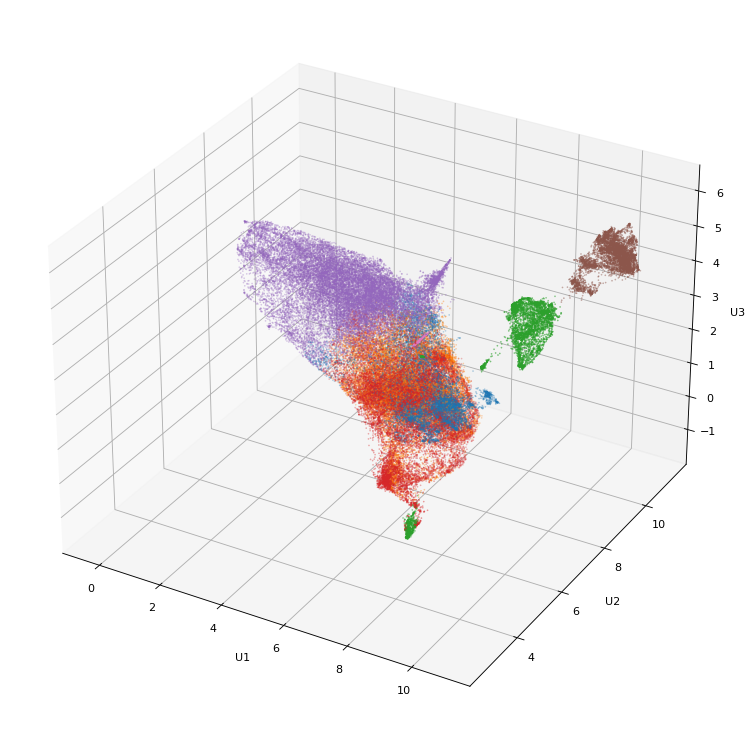

In [ ]:
fig = plt.figure(figsize=(12, 12), dpi=80)
ax = fig.add_subplot(projection='3d')
U_no = [1,2,3]

ax.scatter(
    prop_df_pax_all_static_cluster[['U'+str(U_no[0])]],
    prop_df_pax_all_static_cluster[['U'+str(U_no[1])]],
    prop_df_pax_all_static_cluster[['U'+str(U_no[2])]],
    s=0.2, color=newmap.colors[y_pred.to_numpy()+1,:].squeeze())

ax.set_xlabel('U'+ str(U_no[0]))
ax.set_ylabel('U'+ str(U_no[1]))
ax.set_zlabel('U'+ str(U_no[2]))






Text(0.5, 0, 'U2')

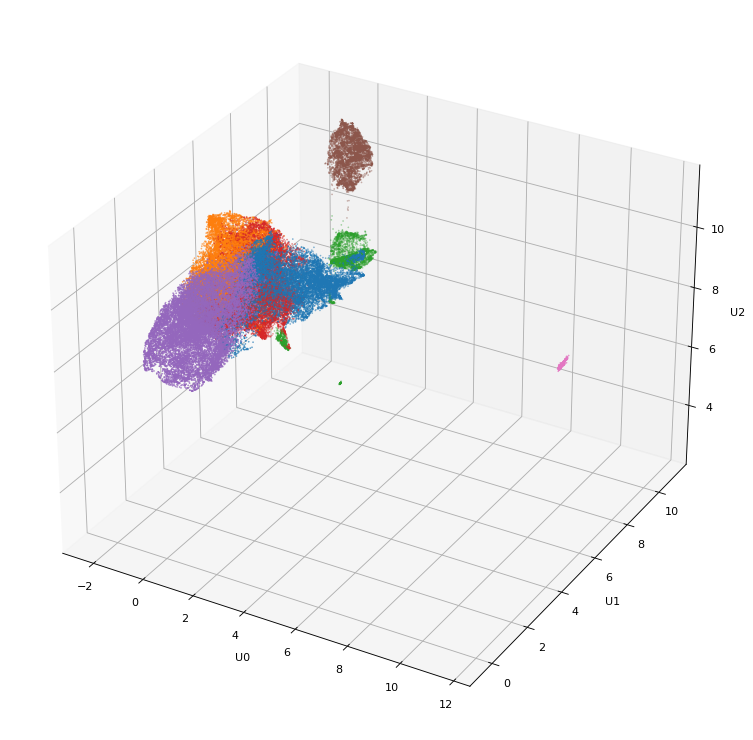

In [ ]:
fig = plt.figure(figsize=(12, 12), dpi=80)
ax = fig.add_subplot(projection='3d')
U_no = [0,1,2]

ax.scatter(
    prop_df_pax_all_static_cluster[['U'+str(U_no[0])]],
    prop_df_pax_all_static_cluster[['U'+str(U_no[1])]],
    prop_df_pax_all_static_cluster[['U'+str(U_no[2])]],
    s=0.2, color=newmap.colors[y_pred.to_numpy()+1,:].squeeze())

ax.set_xlabel('U'+ str(U_no[0]))
ax.set_ylabel('U'+ str(U_no[1]))
ax.set_zlabel('U'+ str(U_no[2]))



Text(0.5, 0, 'U4')

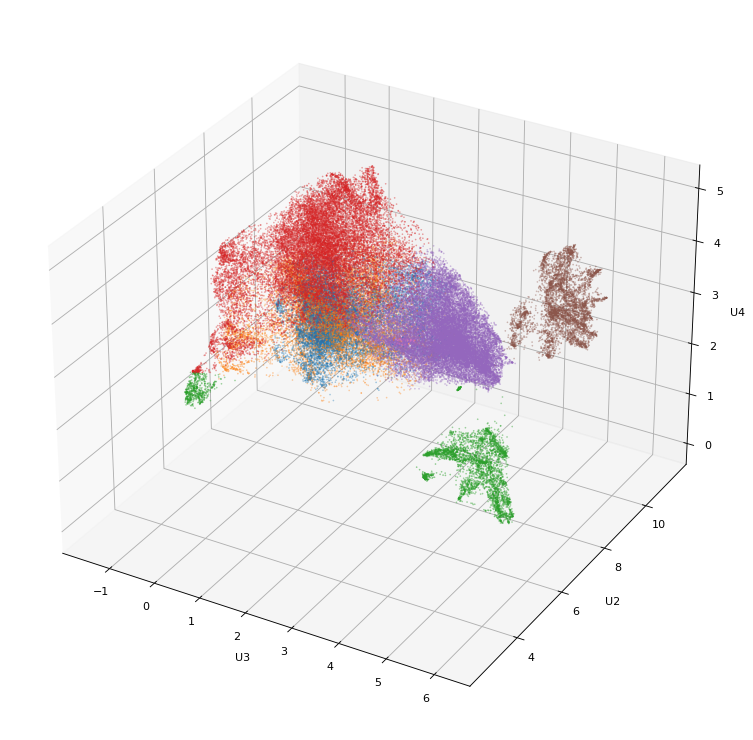

In [ ]:
fig = plt.figure(figsize=(12, 12), dpi=80)
ax = fig.add_subplot(projection='3d')
U_no = [3,2,4]

ax.scatter(
    prop_df_pax_all_static_cluster[['U'+str(U_no[0])]],
    prop_df_pax_all_static_cluster[['U'+str(U_no[1])]],
    prop_df_pax_all_static_cluster[['U'+str(U_no[2])]],
    s=0.2, color=newmap.colors[y_pred.to_numpy()+1,:].squeeze())

ax.set_xlabel('U'+ str(U_no[0]))
ax.set_ylabel('U'+ str(U_no[1]))
ax.set_zlabel('U'+ str(U_no[2]))



In [ ]:
creating 3d plot using matplotlib  
# in python 
  
# for creating a responsive plot 
%matplotlib widget 
  
# importing required libraries 
from mpl_toolkits.mplot3d import Axes3D 
import matplotlib.pyplot as plt 
  

# creating figure 
fig = plt.figure() 
ax = Axes3D(fig) 
  
# creating the plot 
plot_geeks = ax.scatter( embedding[:, 1],
    embedding[:, 2],
    embedding[:, 3]) 
  
# setting title and labels 
ax.set_title("3D plot") 
ax.set_xlabel('U1') 
ax.set_ylabel('U2') 
ax.set_zlabel('U3') 
  
# displaying the plot 
plt.show() 

In [ ]:
prop_df_pax_all_static_cluster[['U'+str(1)]].to_numpy()

In [ ]:
embedding[:,1]



In [ ]:
fig = plt.figure(figsize=(12, 12), dpi=80)
ax = fig.add_subplot(projection='3d')
U_no = [1,2,3]

ax.scatter(
    embedding[:,1],embedding[:,2],embedding[:,3],
    s=0.2, color=newmap.colors[y_pred.to_numpy()+1,:].squeeze())

In [ ]:
fig = plt.figure(figsize=(12, 12), dpi=80)
ax = fig.add_subplot(projection='3d')
U_no = [0,1,3]

ax.scatter(
    X[:, U_no[0]],
    X[:, U_no[1]],
    X[:, U_no[2]],s=2, color=newmap.colors[y_pred.to_numpy()+1,:].squeeze())

ax.set_xlabel('U'+ str(U_no[0]))
ax.set_ylabel('U'+ str(U_no[1]))
ax.set_zlabel('U'+ str(U_no[2]))

In [ ]:
fig = plt.figure(figsize=(12, 12), dpi=80)
ax = fig.add_subplot(projection='3d')
U_no = [3,2,4]

ax.scatter(
    X[:, U_no[0]],
    X[:, U_no[1]],
    X[:, U_no[2]],s=2, color=newmap.colors[y_pred.to_numpy()+1,:].squeeze())

ax.set_xlabel('U'+ str(U_no[0]))
ax.set_ylabel('U'+ str(U_no[1]))
ax.set_zlabel('U'+ str(U_no[2]))